In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [4]:
# Numpy N-dims Array X
# image, image -> 4D tensor --> Train
# Image_generator
#  U-Net Input 2*n
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True: 
    
    # image file 중 32장을 랜덤하게 골라라
    # 32개의 index를 뽑아 줍니다. 
    batch = np.random.choice(files, size = batch_size)

    # list for Image, Mask
    batch_x = []
    batch_y = []
    
    # batch -> list
    for f in batch:
        #get the masks. Note that masks are png files 
        # Image -> Random -> Read -> Resize (256, 256)
        # path = 'annotations/trimaps/{}.png'.format(f[:-4])
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))
        
        #preprocess the binary mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        # if GRAY (256, 256) --> Length of Tuple ? 2
        # elif Color (256, 256, 3) --> Length of Tuple ? 3
        #  GRAY ? Color

        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    # (32, 256, 256)
    batch_y = np.expand_dims(batch_y,3)
    # (32, 256, 256, 1)

    yield (batch_x, batch_y)    
    
    # batch_x: 32, 256, 256, 3
    # batch_y: 32, 256, 256, 1 

In [5]:
batch_size = 32

all_files = os.listdir('images')
# get all files in images folder
# list 
shuffle(all_files)

# len(all_files) -> N? 
# 0.95 -> training, 0.05 --> Validation
split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [6]:
x, y= next(train_generator)

In [7]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


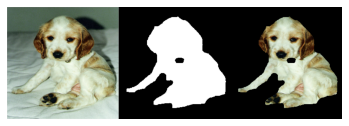

In [8]:
plt.axis('off')
img = x[0]
# (256, 256, 3)
msk = y[0].squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# Image (256, 256, 3) * Mask (256, 256, 3)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [9]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [10]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  nkernels = 64 
  # number of output feature 
  
  layers = []
  # (32, 256, 256, 3)
  layer11 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (x)
  # (32, 256, 256, 64)
  layer12 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer11)
  # (32, 256, 256, 64)
  layer13 = MaxPooling2D() (layer12)
  # (32, 128, 128, 64)

  layer21 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer13)
  # (32, 128, 128, 128)
  layer22 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer21)
  # (32, 128, 128, 128)
  layer23 = MaxPooling2D() (layer22)
  # (32, 64, 64, 128)

  layer31 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer23)
  # (32, 64, 64, 256)
  layer32 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer31)
  # (32, 64, 64, 256)
  layer33 = MaxPooling2D() (layer32)
  # (32, 32, 32, 256)

  layer41 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer33)
  # (32, 32, 32, 512)
  layer42 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer41)
  # (32, 32, 32, 512)
  layer43 = MaxPooling2D() (layer42)
  # (32, 16, 16, 512)

  layer51 = Conv2D(nkernels*16, (3,3), activation='relu', padding='same') (layer43)
  # (32, 16, 16, 1024)

  layer52 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer51)
  # (32, 16, 16, 512)

  layer61 = UpSampling2D()(layer52)
  # (32, 32, 32, 512)
  layer62 = Concatenate(axis=3)([layer61, layer42])
  # (32, 32, 32, 1024)
  layer63 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer62)
  # (32, 32, 32, 512)
  layer64 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer63)
  # (32, 32, 32, 256)

  layer71 = UpSampling2D()(layer64)
  # (32, 64, 64, 256)
  layer72 = Concatenate(axis=3)([layer71, layer32])
  # (32, 64, 64, 512)
  layer73 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer72)
  # (32, 64, 64, 256)
  layer74 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer73)
  # (32, 64, 64, 128)

  layer81 = UpSampling2D()(layer74)
  # (32, 128, 128, 128)
  layer82 = Concatenate(axis=3)([layer81, layer22])
  # (32, 128, 128, 256)
  layer83 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer82)
  # (32, 128, 128, 128)
  layer84 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer83)
  # (32, 128, 128, 64)

  layer91 = UpSampling2D()(layer84)
  # (32, 256, 256, 64)
  layer92 = Concatenate(axis=3)([layer91, layer12])
  # (32, 256, 256, 128)
  layer93 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer92)
  # (32, 256, 256, 64)
  layer94 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer93)
  # (32, 256, 256, 64)

  outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same') (layer94)
  # (32, 256, 256, 1)

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [11]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [12]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training


i= 1 loss= 29.328062074233408 val_loss= 0.5863622426986694 mean_iou= 0.0025795398 val_mean_iou= 0.0


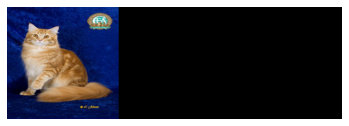

i= 2 loss= 0.6514175497505763 val_loss= 0.5522429943084717 mean_iou= 0.0018894286 val_mean_iou= 0.0


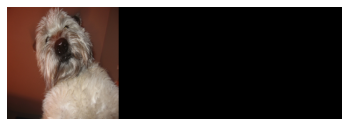

i= 3 loss= 0.5438854173166022 val_loss= 0.5156310796737671 mean_iou= 0.2095817 val_mean_iou= 0.44703972339630127


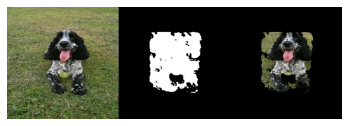

i= 4 loss= 0.45891882649295407 val_loss= 0.4913176894187927 mean_iou= 0.4218179 val_mean_iou= 0.494404673576355


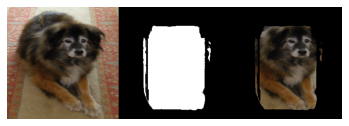

i= 5 loss= 0.4378020029906268 val_loss= 0.4080146253108978 mean_iou= 0.45264092 val_mean_iou= 0.4873512089252472


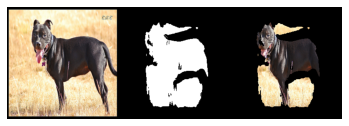

i= 6 loss= 0.41296492346889896 val_loss= 0.3416939973831177 mean_iou= 0.48649952 val_mean_iou= 0.5234370827674866


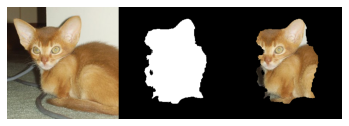

i= 7 loss= 0.3777063727106678 val_loss= 0.2627003788948059 mean_iou= 0.5395733 val_mean_iou= 0.6397275924682617


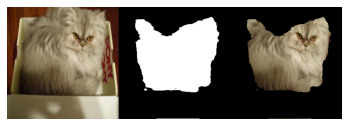

i= 8 loss= 0.3404739788950306 val_loss= 0.2863914370536804 mean_iou= 0.5896127 val_mean_iou= 0.6301710605621338


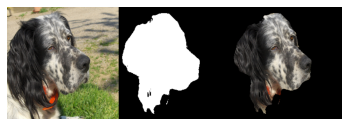

i= 9 loss= 0.3057517788998068 val_loss= 0.3043181598186493 mean_iou= 0.6265079 val_mean_iou= 0.5473442673683167


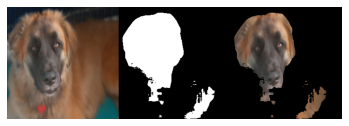

i= 10 loss= 0.281062423298348 val_loss= 0.24173656105995178 mean_iou= 0.66072786 val_mean_iou= 0.6989742517471313


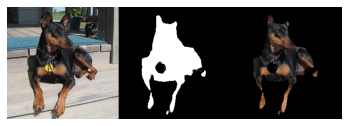

i= 11 loss= 0.2677387092347559 val_loss= 0.2390236258506775 mean_iou= 0.6796975 val_mean_iou= 0.7143503427505493


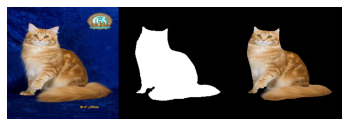

i= 12 loss= 0.24196336374163083 val_loss= 0.23469865322113037 mean_iou= 0.7076489 val_mean_iou= 0.7398717403411865


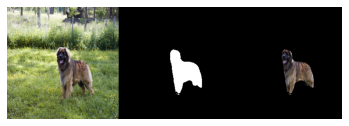

i= 13 loss= 0.23282060483002773 val_loss= 0.19675594568252563 mean_iou= 0.7251366 val_mean_iou= 0.7505449056625366


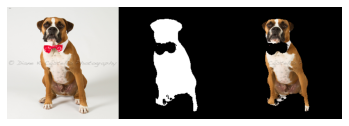

i= 14 loss= 0.21377144264031764 val_loss= 0.20583660900592804 mean_iou= 0.7437517 val_mean_iou= 0.7650900483131409


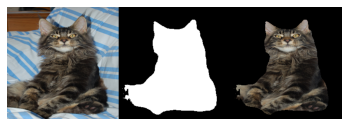

i= 15 loss= 0.20295285511778915 val_loss= 0.1853729486465454 mean_iou= 0.7549813 val_mean_iou= 0.7708281874656677


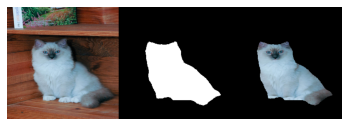

i= 16 loss= 0.1973633901577562 val_loss= 0.18591125309467316 mean_iou= 0.76257974 val_mean_iou= 0.7602154016494751


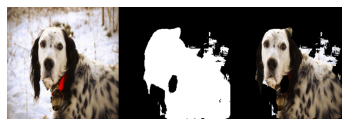

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

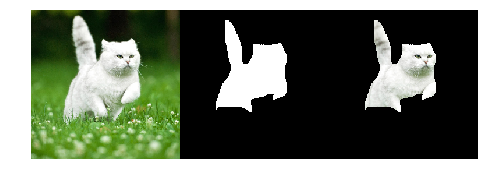

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

